In [1]:
import pandas as pd
import numpy as np
from pathlib import Path
import os
import sys
import torch
from torch.utils.data import DataLoader, Dataset
from properscoring import crps_ensemble
import random


sys.path.append(os.path.abspath('../src'))
project_dir = Path.cwd().parent

from data_tools.data_utils import SeroDataset, PartialCountDataset, TrueCountDataset
from model_tools.train_utils import BaseTrain, SparsePropTrain, SeroTrain
from model_tools.models import NowcastPNN, PropPNN, SparsePropPNN, SeroPNN
from model_tools.evaluation import eval_pnn, eval_prop_pnn, eval_sparse_prop_pnn, eval_sero_pnn, plot_pnn_preds, plot_prop_pnn_preds, plot_sero_pnn_preds
D = 40
M = 50
T = 10

start_year = 2014
end_year = 2022
data_split = [0.7, 0.15, 0.15]
seed = 123

def set_seed(seed=0):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False




In [2]:
# Create serotype obj
denv_df = pd.read_csv(project_dir / "data" / "transformed" / "denv_df.csv")
sero_props = pd.read_csv(project_dir / "data" / "transformed" / "sero_props.csv")

denv_df['Collection date'] = pd.to_datetime(denv_df['Collection date']).dt.to_period('M')
denv_df['Submission date'] = pd.to_datetime(denv_df['Submission date']).dt.to_period('M')
sero_props['Collection date'] = pd.to_datetime(sero_props['Collection date']).dt.to_period('M')
sero_dataset = SeroDataset(denv_df, sero_props, T=T)

In [3]:
# Create count obj
delays_df = pd.read_csv(project_dir / "data" / "transformed" / "DENG_delays.csv")
delays_df['Collection date'] = pd.to_datetime(delays_df['Collection date'])

partial_count_dataset = PartialCountDataset(delays_df, D=D, M=M)
true_count_dataset = TrueCountDataset(delays_df)


In [4]:
# End of 2023 appears to have some incomplete data

dates = list(pd.date_range(f"{start_year}-01-01",f"{end_year}-12-31", freq='D'))
data_split_sizes = (np.array(data_split) * len(dates)).astype(int)

# Ensure dates line up fully, also removing 2023-12-31 as doesn't appear complete
data_split_sizes[-1] = len(dates) - data_split_sizes[:-1].sum()


train_dates = dates[:data_split_sizes[0]]
val_dates = dates[data_split_sizes[0]:data_split_sizes[0]+data_split_sizes[1]]
test_dates = dates[data_split_sizes[0]+data_split_sizes[1]:]


In [5]:
class PNNDataset(Dataset):
    def __init__(self, partial_count_obj, true_count_obj, dates):
        self.partial_count_obj = partial_count_obj
        self.true_count_obj = true_count_obj
        self.dates = dates
    
    def __len__(self):
        return len(self.dates)
    
    def __getitem__(self, index):
        date = self.dates[index]
        obs = self.partial_count_obj.get_obs(date)
        y = self.true_count_obj.get_y(date)
        dow = date.day_of_week
        return (obs, dow), y

set_seed(seed)
train_pnn_dataset = PNNDataset(partial_count_dataset, true_count_dataset, train_dates)
val_pnn_dataset = PNNDataset(partial_count_dataset, true_count_dataset, val_dates)
test_pnn_dataset = PNNDataset(partial_count_dataset, true_count_dataset, test_dates)

g = torch.Generator()
g.manual_seed(seed)

train_loader = DataLoader(train_pnn_dataset, batch_size=32, shuffle=True, generator=g)
val_loader = DataLoader(val_pnn_dataset, batch_size=32, shuffle=False)
test_loader = DataLoader(test_pnn_dataset, batch_size=32, shuffle=False)


In [6]:
# pnn_model = NowcastPNN(M=M, D=D, hidden_units = [16, 8], conv_channels = [16, 1], embedding_dim = 10, dropout_probs = [0.15, 0.1], device="cpu")
# pnn_train = BaseTrain("PNN")
# pnn_train.train_model(pnn_model, train_loader, val_loader)

In [7]:
# pnn_model = NowcastPNN(M=M, D=D, hidden_units = [16, 8], conv_channels = [16, 1], embedding_dim = 10, dropout_probs = [0.15, 0.1], device="cpu")
# pnn_model.load_state_dict(torch.load(project_dir /"src" / "outputs" / "weights" / f"weights-PNN"))

# pnn_train_samples, train_y_true = eval_pnn(train_pnn_dataset, pnn_model)


# plot_pnn_preds(pnn_train_samples,train_pnn_dataset, "PNN Train Performance")
# print(f"CRPS: {crps_ensemble(train_y_true.squeeze(-1), pnn_train_samples).mean()}")

In [8]:
# pnn_val_samples, val_y_true = eval_pnn(val_pnn_dataset, pnn_model)
# plot_pnn_preds(pnn_val_samples,val_pnn_dataset, "PNN Val Performance")
# print(f"CRPS: {crps_ensemble(val_y_true.squeeze(-1), pnn_val_samples).mean()}")

In [9]:
# pnn_test_samples, test_y_true = eval_pnn(test_pnn_dataset, pnn_model)
# plot_pnn_preds(pnn_test_samples,test_pnn_dataset, "PNN Test Performance")
# print(f"CRPS: {crps_ensemble(test_y_true.squeeze(-1), pnn_test_samples).mean()}")

In [10]:
# class PropPNNDataset(Dataset):
#     def __init__(self, partial_count_obj, true_count_obj, dates):
#         self.partial_count_obj = partial_count_obj
#         self.true_count_obj = true_count_obj
#         self.dates = dates
    
#     def __len__(self):
#         return len(self.dates)
    
#     def __getitem__(self, index):
#         date = self.dates[index]
#         obs = self.partial_count_obj.get_obs(date)
#         z = self.true_count_obj.get_z(date)
#         dow = date.day_of_week
#         return (obs, dow), z

# set_seed(seed)
# train_prop_pnn_dataset = PropPNNDataset(partial_count_dataset, true_count_dataset, train_dates)
# val_prop_pnn_dataset = PropPNNDataset(partial_count_dataset, true_count_dataset, val_dates)
# test_prop_pnn_dataset = PropPNNDataset(partial_count_dataset, true_count_dataset, test_dates)

# g = torch.Generator()
# g.manual_seed(seed)

# train_loader = DataLoader(train_prop_pnn_dataset, batch_size=32, shuffle=True, generator=g)
# val_loader = DataLoader(val_prop_pnn_dataset, batch_size=32, shuffle=False)
# test_loader = DataLoader(test_prop_pnn_dataset, batch_size=32, shuffle=False)


In [11]:
# prop_pnn_model = PropPNN(M=M, D=D, hidden_units = [16, 8], conv_channels = [16, 1], embedding_dim = 10, dropout_probs = [0.15, 0.1], device="cpu")
# prop_pnn_train = BaseTrain("PropPNN")
# prop_pnn_train.train_model(prop_pnn_model, train_loader, val_loader)

In [12]:
# prop_pnn_model = PropPNN(M=M, D=D, hidden_units = [16, 8], conv_channels = [16, 1], embedding_dim = 10, dropout_probs = [0.15, 0.1], device="cpu")
# prop_pnn_model.load_state_dict(torch.load(project_dir /"src" / "outputs" / "weights" / f"weights-PropPNN"))

# prop_pnn_train_samples, train_z_true = eval_prop_pnn(train_prop_pnn_dataset, prop_pnn_model)
# plot_prop_pnn_preds(prop_pnn_train_samples,train_prop_pnn_dataset, "PropPNN Train Performance")

# train_y_true = train_z_true.sum(-1)
# print(f"CRPS: {crps_ensemble(train_y_true.squeeze(-1), prop_pnn_train_samples).mean()}")

In [13]:
# prop_pnn_val_samples, val_z_true = eval_prop_pnn(val_prop_pnn_dataset, prop_pnn_model)
# plot_prop_pnn_preds(prop_pnn_val_samples,val_prop_pnn_dataset, "PropPNN Val Performance")

# val_y_true = val_z_true.sum(-1)
# print(f"CRPS: {crps_ensemble(val_y_true.squeeze(-1), prop_pnn_val_samples).mean()}")

In [14]:
# prop_pnn_test_samples, test_z_true = eval_prop_pnn(test_prop_pnn_dataset, prop_pnn_model)
# plot_prop_pnn_preds(prop_pnn_test_samples,test_prop_pnn_dataset, "PropPNN Test Performance")

# test_y_true = test_z_true.sum(-1)
# print(f"CRPS: {crps_ensemble(test_y_true.squeeze(-1), prop_pnn_test_samples).mean()}")

In [15]:
# set_seed(seed)
# train_prop_pnn_dataset = PropPNNDataset(partial_count_dataset, true_count_dataset, train_dates)
# val_prop_pnn_dataset = PropPNNDataset(partial_count_dataset, true_count_dataset, val_dates)
# test_prop_pnn_dataset = PropPNNDataset(partial_count_dataset, true_count_dataset, test_dates)

# g = torch.Generator()
# g.manual_seed(seed)

# train_loader = DataLoader(train_prop_pnn_dataset, batch_size=32, shuffle=True, generator=g)
# val_loader = DataLoader(val_prop_pnn_dataset, batch_size=32, shuffle=False)
# test_loader = DataLoader(test_prop_pnn_dataset, batch_size=32, shuffle=False)


In [16]:
# sparse_prop_pnn_model = SparsePropPNN(M=M, D=D, hidden_units = [16, 8], conv_channels = [16, 1], embedding_dim = 10, dropout_probs = [0.15, 0.1], device="cpu")
# sparse_prop_pnn_train = SparsePropTrain("SparsePropPNN")
# sparse_prop_pnn_train.train_model(sparse_prop_pnn_model, train_loader, val_loader)

In [17]:
# sparse_prop_pnn_model = SparsePropPNN(M=M, D=D, hidden_units = [16, 8], conv_channels = [16, 1], embedding_dim = 10, dropout_probs = [0.15, 0.1], device="cpu")
# sparse_prop_pnn_model.load_state_dict(torch.load(project_dir /"src" / "outputs" / "weights" / f"weights-SparsePropPNN"))

# sparse_prop_pnn_train_samples, train_z_true = eval_sparse_prop_pnn(train_prop_pnn_dataset, sparse_prop_pnn_model)
# plot_prop_pnn_preds(sparse_prop_pnn_train_samples,train_prop_pnn_dataset, "SparsePropPNN Train Performance")

# train_y_true = train_z_true.sum(-1)
# print(f"CRPS: {crps_ensemble(train_y_true.squeeze(-1), sparse_prop_pnn_train_samples).mean()}")

# sparse_prop_pnn_val_samples, val_z_true = eval_sparse_prop_pnn(val_prop_pnn_dataset, sparse_prop_pnn_model)
# plot_prop_pnn_preds(sparse_prop_pnn_val_samples,val_prop_pnn_dataset, "SparsePropPNN Val Performance")

# val_y_true = val_z_true.sum(-1)
# print(f"CRPS: {crps_ensemble(val_y_true.squeeze(-1), sparse_prop_pnn_val_samples).mean()}")

# sparse_prop_pnn_test_samples, test_z_true = eval_sparse_prop_pnn(test_prop_pnn_dataset, sparse_prop_pnn_model)
# plot_prop_pnn_preds(sparse_prop_pnn_test_samples,test_prop_pnn_dataset, "SparsePropPNN Test Performance")

# test_y_true = test_z_true.sum(-1)
# print(f"CRPS: {crps_ensemble(test_y_true.squeeze(-1), sparse_prop_pnn_test_samples).mean()}")

In [18]:
class SeroPNNDataset(Dataset):
    def __init__(self, partial_count_obj, true_count_obj, sero_obj, dates):
        self.partial_count_obj = partial_count_obj
        self.true_count_obj = true_count_obj
        self.sero_obj = sero_obj
        self.dates = dates
    
    def __len__(self):
        return len(self.dates)
    
    def __getitem__(self, index):
        date = self.dates[index]
        obs = self.partial_count_obj.get_obs(date)
        sero_obs = self.sero_obj.get_obs(date)
        prop_vec = self.sero_obj.get_prop_vec(date)
        y = self.true_count_obj.get_y_prop(date, prop_vec)
        dow = date.day_of_week
        return (obs, dow, sero_obs), y

set_seed(seed)
sero_props = pd.read_csv(project_dir / "data" / "transformed" / "sero_props.csv")


train_sero_pnn_dataset = SeroPNNDataset(partial_count_dataset, true_count_dataset, sero_dataset, train_dates)
val_sero_pnn_dataset = SeroPNNDataset(partial_count_dataset, true_count_dataset, sero_dataset, val_dates)
test_sero_pnn_dataset = SeroPNNDataset(partial_count_dataset, true_count_dataset,  sero_dataset, test_dates)

g = torch.Generator()
g.manual_seed(seed)

train_loader = DataLoader(train_sero_pnn_dataset, batch_size=32, shuffle=True, generator=g)
val_loader = DataLoader(val_sero_pnn_dataset, batch_size=32, shuffle=False)
test_loader = DataLoader(test_sero_pnn_dataset, batch_size=32, shuffle=False)


In [19]:
N = len(sero_dataset.get_prop_vec("2020-01-01"))
sero_pnn_model = SeroPNN(M=M, D=D, T=T, N=N, hidden_units = [16, 8], conv_channels = [16, 1], embedding_dim = 10, dropout_probs = [0.15, 0.1], device="cpu")
sero_pnn_train = SeroTrain("SeroPNN", lr=0.0003)
sero_pnn_train.train_model(sero_pnn_model, train_loader, val_loader)



Epoch 1 - Train loss: 2.3e+05 - Val loss: 2.49e+06 - ES count: 0
Epoch 2 - Train loss: 1.5e+05 - Val loss: 2.07e+06 - ES count: 0
Epoch 3 - Train loss: 1.15e+05 - Val loss: 1.78e+06 - ES count: 0
Epoch 4 - Train loss: 1.04e+05 - Val loss: 1.76e+06 - ES count: 0
Epoch 5 - Train loss: 9.54e+04 - Val loss: 1.53e+06 - ES count: 0
Epoch 6 - Train loss: 8.78e+04 - Val loss: 1.7e+06 - ES count: 1
Epoch 7 - Train loss: 8.2e+04 - Val loss: 1.33e+06 - ES count: 0
Epoch 8 - Train loss: 7.34e+04 - Val loss: 1.18e+06 - ES count: 0
Epoch 9 - Train loss: 6.71e+04 - Val loss: 1.11e+06 - ES count: 0
Epoch 10 - Train loss: 7.23e+04 - Val loss: 1.18e+06 - ES count: 1
Epoch 11 - Train loss: 6.22e+04 - Val loss: 9.5e+05 - ES count: 0
Epoch 12 - Train loss: 7.56e+04 - Val loss: 1.08e+06 - ES count: 1
Epoch 13 - Train loss: 6.69e+04 - Val loss: 9.98e+05 - ES count: 2
Epoch 14 - Train loss: 6.8e+04 - Val loss: 9.1e+05 - ES count: 0
Epoch 15 - Train loss: 6.41e+04 - Val loss: 8.22e+05 - ES count: 0
Epoch 16 - 

KeyboardInterrupt: 

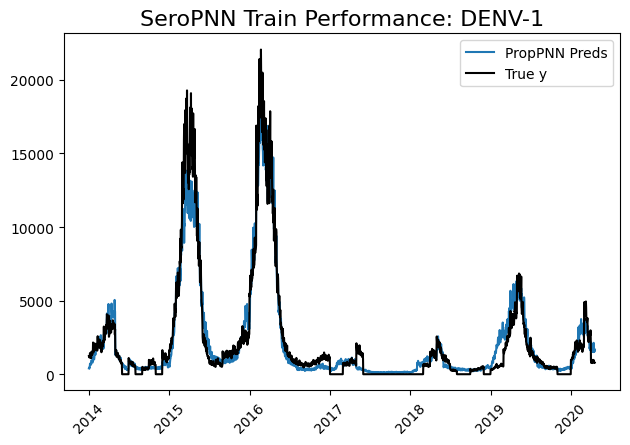

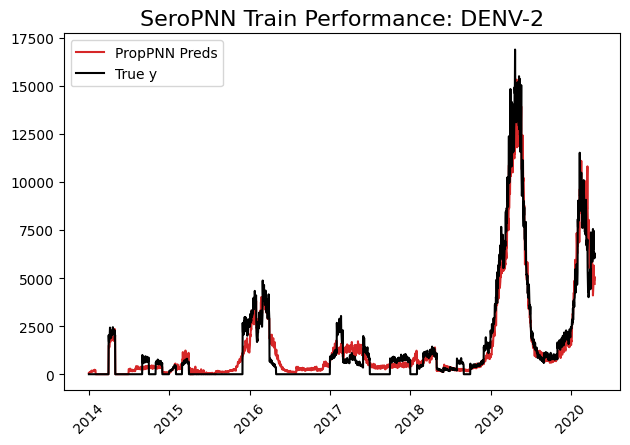

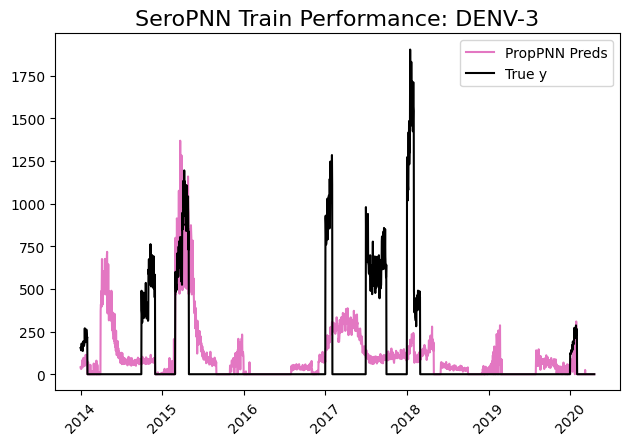

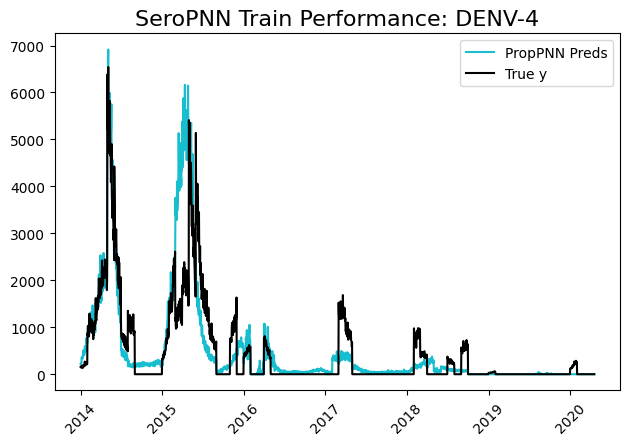

CRPS: 1129.3903686956521


In [20]:
N = len(sero_dataset.get_prop_vec("2020-01-01"))
sero_pnn_model = SeroPNN(M=M, D=D, T=T, N=N, hidden_units = [16, 8], conv_channels = [16, 1], embedding_dim = 10, dropout_probs = [0.15, 0.1], device="cpu")
sero_pnn_model.load_state_dict(torch.load(project_dir /"src" / "outputs" / "weights" / f"weights-SeroPNN"))

sero_pnn_train_samples, train_y_true = eval_sero_pnn(train_sero_pnn_dataset, sero_pnn_model, N=N)
plot_sero_pnn_preds(sero_pnn_train_samples, train_sero_pnn_dataset, N, "SeroPNN Train Performance")

crps = 0
crps = sum([crps_ensemble(train_y_true[:,s], sero_pnn_train_samples[:,s,:]).mean() for s in range(N)])
print(f"CRPS: {crps}")


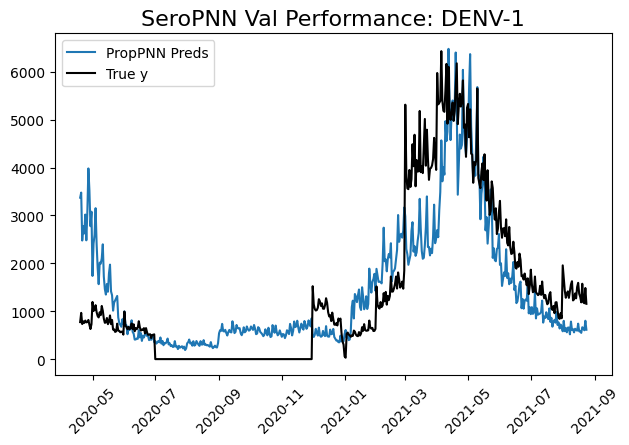

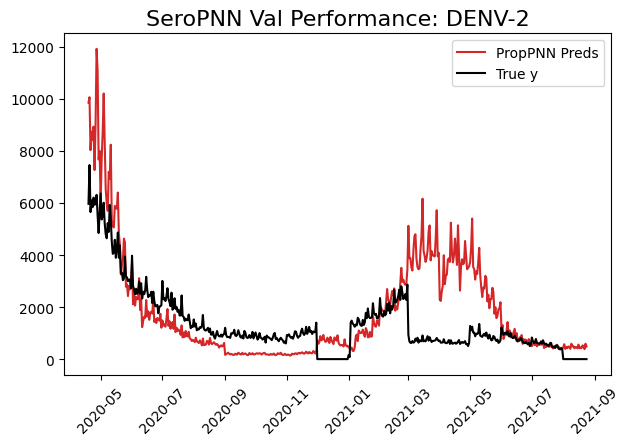

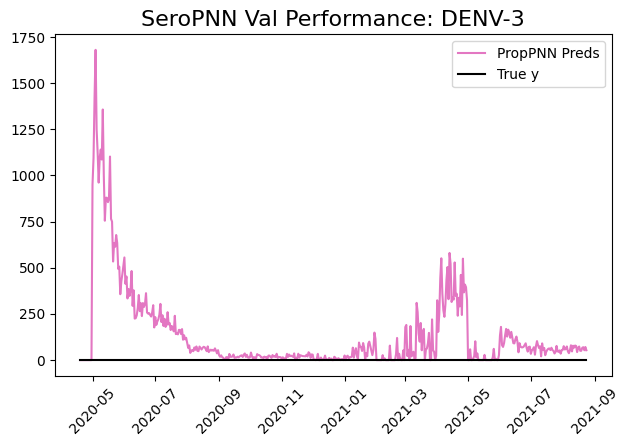

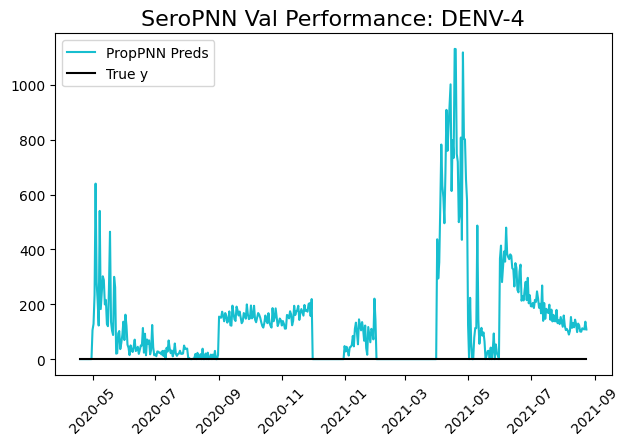

CRPS: 1580.629664908722


In [21]:
sero_pnn_val_samples, val_y_true = eval_sero_pnn(val_sero_pnn_dataset, sero_pnn_model, N=N)
plot_sero_pnn_preds(sero_pnn_val_samples, val_sero_pnn_dataset, N, "SeroPNN Val Performance")

crps = 0
crps = sum([crps_ensemble(val_y_true[:,s], sero_pnn_val_samples[:,s,:]).mean() for s in range(N)])
print(f"CRPS: {crps}")

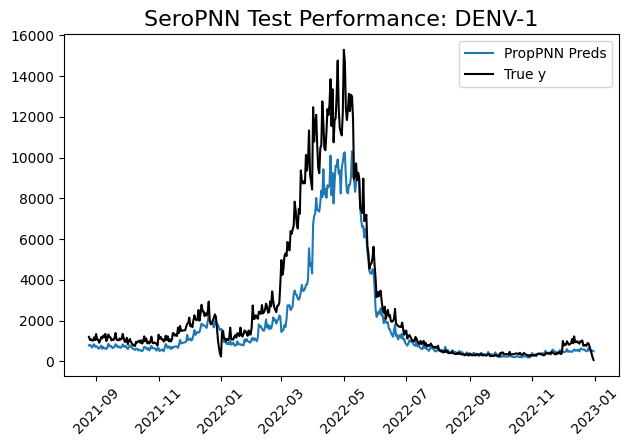

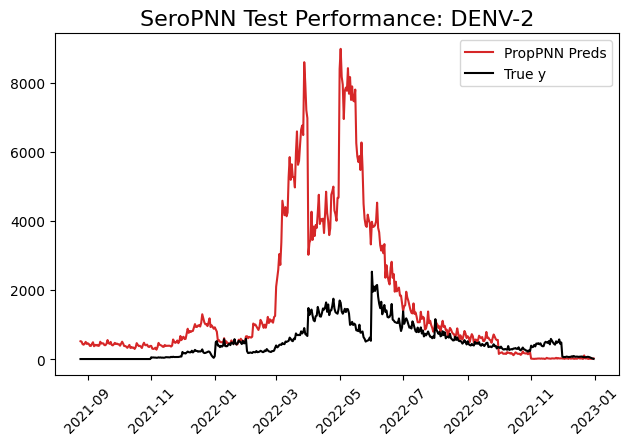

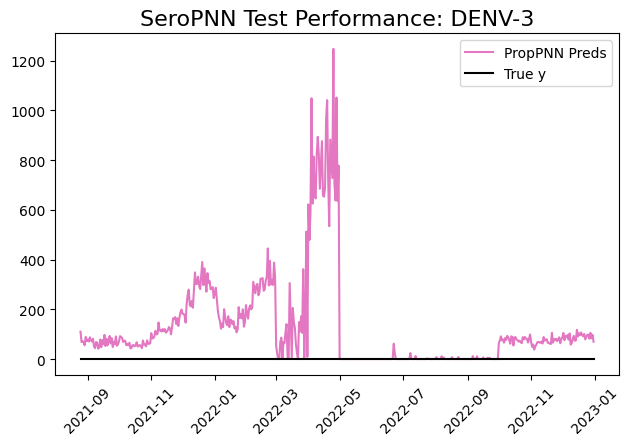

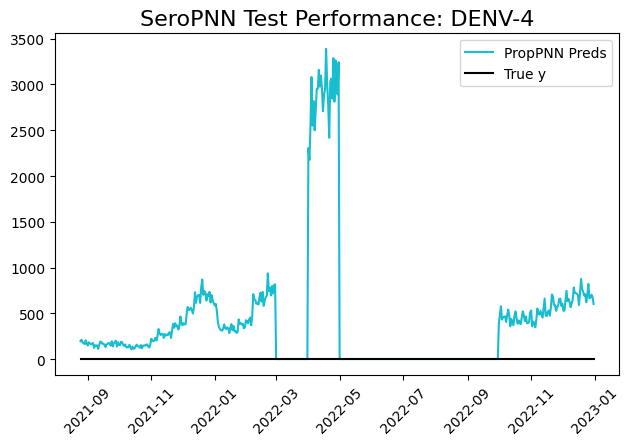

CRPS: 2039.500379757085


In [22]:
sero_pnn_test_samples, test_y_true = eval_sero_pnn(test_sero_pnn_dataset, sero_pnn_model, N=N)
plot_sero_pnn_preds(sero_pnn_test_samples, test_sero_pnn_dataset, N, "SeroPNN Test Performance")

crps = 0
crps = sum([crps_ensemble(test_y_true[:,s], sero_pnn_test_samples[:,s,:]).mean() for s in range(N)])
print(f"CRPS: {crps}")